#### Imports

In [45]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')


### Device Setting

In [46]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [47]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

#### Dataset class

In [72]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name).convert('RGB')

        target = torch.tensor(self.df['loss_percentage'].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

In [73]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [74]:
custom_dataset = CustomDataset(csv_file='filtered_data.csv', img_folder='SolarPanelSoilingImageDataset\Solar_Panel_Soiling_Image_dataset\Pytorch_data/', transform=transform)

dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


### Visualize the loaded data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

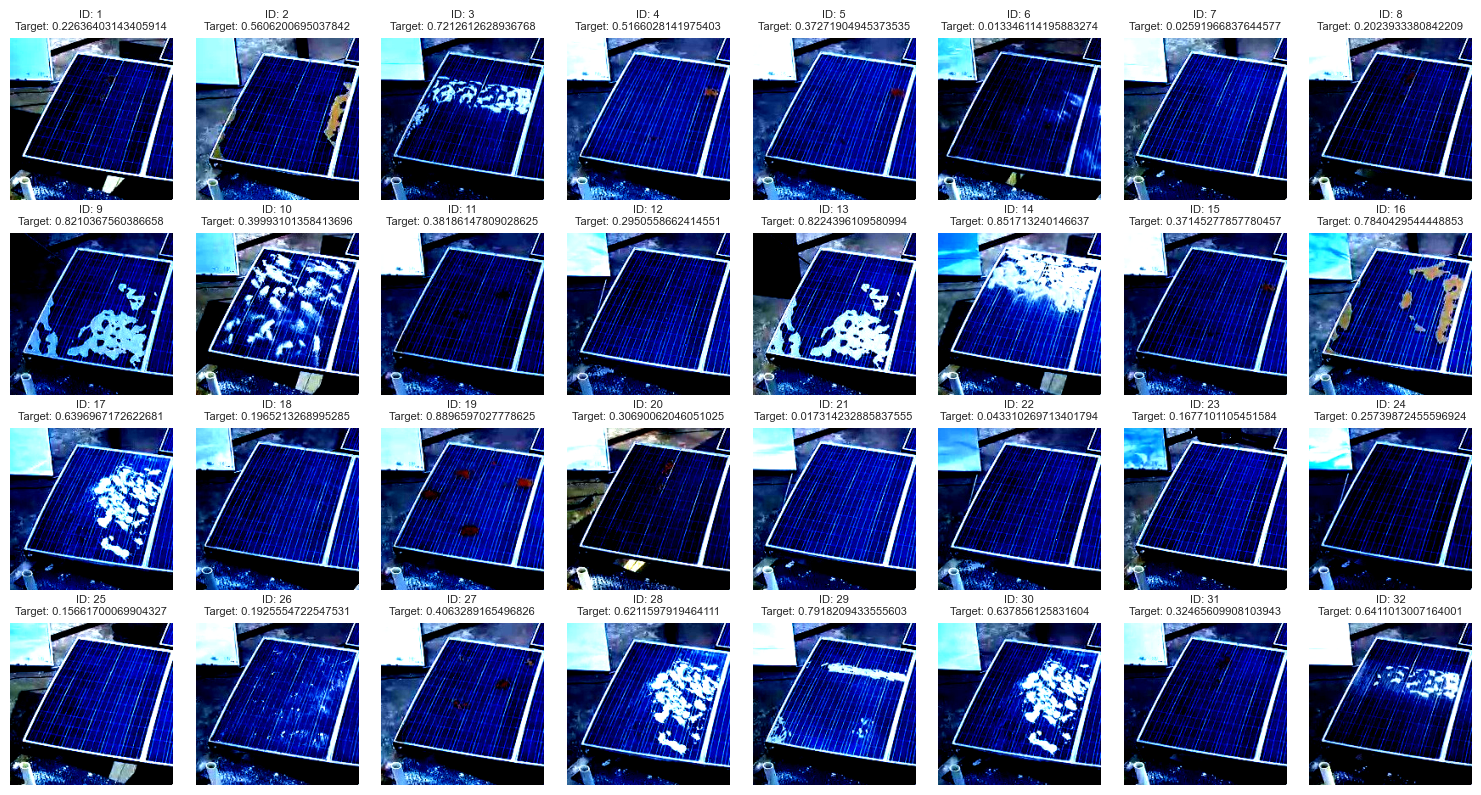

In [75]:
images, targets = next(iter(dataloader))

# Convert images to numpy arrays
np_images = images.numpy()

# Define the size of the grid
num_rows = 4
num_cols = 8

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Visualize each image along with its target and ID from the folder
for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))  # Change the order of dimensions for displaying with matplotlib
    target = targets[i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nTarget: {target}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Train Test Split


In [64]:
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.3 , shuffle=True)

# Create DataLoader instances for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [65]:
sample = next(iter(dataloader))

input_image, target = sample

print("Input image dimensions:", input_image.shape)
print("Target value:", target)

Input image dimensions: torch.Size([32, 3, 192, 192])
Target value: tensor([0.9367, 0.6286, 0.3327, 0.6396, 0.6415, 0.2032, 0.1888, 0.3977, 0.3954,
        0.8017, 0.3824, 0.6679, 0.1531, 0.5817, 0.1539, 0.2781, 0.8444, 0.6424,
        0.4961, 0.7304, 0.9024, 0.6255, 0.0159, 0.5479, 0.9020, 0.6709, 0.8873,
        0.7418, 0.0760, 0.9147, 0.3546, 0.6639])


### NN Architecture / Regression and Classification

#### Regression

In [81]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48 // 4, 512)  # Adjusted for 192x192 images with max pooling
        self.fc2 = nn.Linear(512, 1)  # Output layer for regression

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for fully connected layers
        x = x.view(-1, 128 * 48 * 48 // 4)  # Adjusted for 192x192 images with max pooling

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#### Classification

In [66]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 48 * 48, 512)  # Adjust the input size based on your image size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = self.pool(x)

        # Flatten before fully connected layers
        x = x.view(-1, 256 * 48 * 48)  # Adjust the size based on your image size

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


#### Training Functions

#### **Train Regression**

In [91]:
def train(model, dataloader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch', position=0, leave=True) as pbar:
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


#### Train

In [92]:
model = RegressionCNN()

In [93]:
train(model, train_dataloader, num_epochs=3)

Epoch 1/3: 100%|██████████| 506/506 [11:31<00:00,  1.37s/batch, loss=0.786]


Epoch 1/3, Loss: 0.7880


Epoch 2/3: 100%|██████████| 506/506 [12:45<00:00,  1.51s/batch, loss=0.0779]


Epoch 2/3, Loss: 0.0780


Epoch 3/3: 100%|██████████| 506/506 [16:29<00:00,  1.96s/batch, loss=0.077] 

Epoch 3/3, Loss: 0.0772


#### Test

In [99]:
def test_regression(model, dataloader):
    model.eval()
    all_targets = []
    all_predictions = []

    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            all_targets.extend(targets.numpy())
            all_predictions.extend(outputs.numpy())

    mse = np.mean((np.array(all_targets) - np.array(all_predictions))**2)
    print(f'Mean Squared Error (MSE): {mse:.4f}')

In [100]:
test_regression(model, test_dataloader)

Mean Squared Error (MSE): 0.0716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

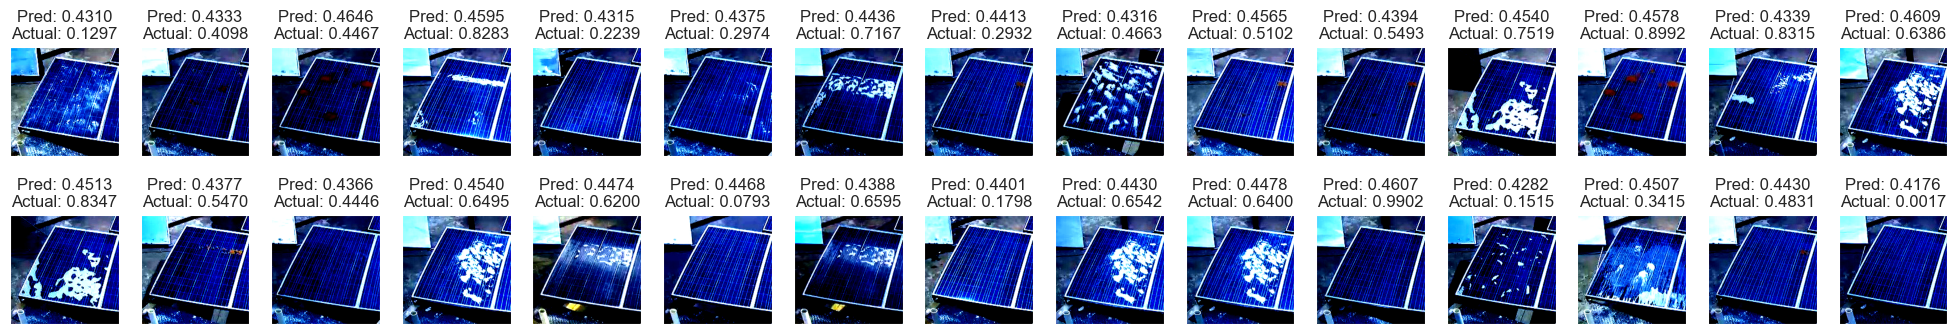

In [101]:
for images, targets in test_dataloader:
    break

outputs = model(images)
predictions = outputs.detach().numpy()

images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in range(30):  # Adjust the number of samples to visualize as needed
    ax = fig.add_subplot(2, 15, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))  # Assuming images are in (batch_size, channels, height, width) format

    # Set the title with predicted and true values
    ax.set_title('Pred: {:.4f}\nActual: {:.4f}'.format(predictions[idx][0], targets[idx].item()))

plt.show()